# Obtaining a training dataset

In [1]:
import importlib

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import xarray as xr
from dask.distributed import Client

from modules import stats
importlib.reload(stats)

<module 'modules.stats' from '/srv/ccrc/AtmSS/z5310829/honours_project/modules/stats.py'>

In [24]:
client = Client(n_workers=8, threads_per_worker=1, memory_limit='8GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 8,Total memory: 59.60 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39283,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 59.60 GiB
Comm: tcp://127.0.0.1:37271,Total threads: 1
Dashboard: http://127.0.0.1:40533/status,Memory: 7.45 GiB
Nanny: tcp://127.0.0.1:44667,


## Temporal autocorrelation

In [4]:
data = xr.open_mfdataset('../data/control/1024_192/*.nc')
data = data.isel(t=(data.t <= 300))

In [37]:
def _autocorrelation(array, max_lag):
    result = np.zeros(max_lag + 1)
    result[0] = np.mean(array**2)
    for lag in range(1, max_lag + 1):
        result[lag] = np.mean(array[..., lag:]*array[..., :-lag])
    return result

def autocorrelation(array, axis, max_lag):
    step = array[axis].diff(axis)
    if not np.allclose(step, step[0]):
        raise ValueError('Coordinate must have regular steps.')
    n_max_lag = int(max_lag//step[0])
    result = xr.apply_ufunc(
        _autocorrelation, array, kwargs={'max_lag': n_max_lag},
        input_core_dims=[list(array.dims)], output_core_dims=[[axis + '_lag']],
        dask='allowed',
    )
    return result

In [38]:
u_corr = autocorrelation(data.u, 't', 1.)

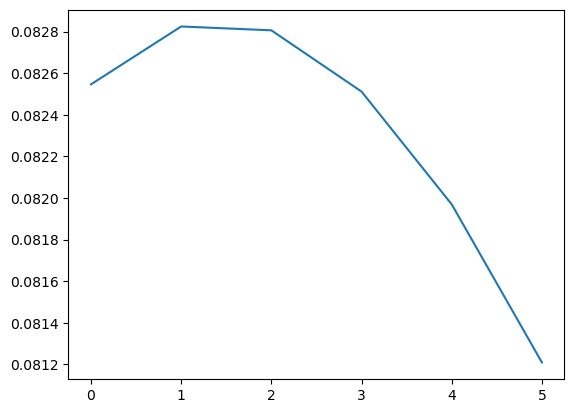

In [33]:
plt.plot(u_corr)

In [39]:
client.close()